In [ ]:
# ---imports---
import numpy as np
import pandas as pd

# Küçük batch-fermantasyon datası
data = """Time_h,Biomass_gL,Glucose_gL
0,0.2,50
2,0.6,44
4,1.5,38
6,2.7,31
8,3.8,24
10,4.5,18
12,4.8,13
14,4.9,9
16,5.0,6
18,5.0,4
"""

# Dosya oluştur ve oku
with open("fermentation_data.csv", "w") as f:
    f.write(data)

df = pd.read_csv("fermentation_data.csv")
df

,Time_h,Biomass_gL,Glucose_gL
0,0,0.2,50
1,2,0.6,44
2,4,1.5,38
3,6,2.7,31
4,8,3.8,24
5,10,4.5,18
6,12,4.8,13
7,14,4.9,9
8,16,5.0,6
9,18,5.0,4


In [ ]:
eps = 1e-9                        # log(0) hatasından kaçınmak için
lnX = np.log(np.clip(df["Biomass_gL"].values, eps, None))
t   = df["Time_h"].values
mu_est = np.diff(lnX) / np.diff(t)       # spesifik büyüme hızı (1/h)

S = df["Glucose_gL"].values
S_mid = 0.5 * (S[1:] + S[:-1])           # aralıkların ortalama substratı

monod_df = pd.DataFrame({
    "S_mid": S_mid,
    "mu_est": mu_est
})
monod_df

,S_mid,mu_est
0,47.0,0.549306
1,41.0,0.458145
2,34.5,0.293893
3,27.5,0.170875
4,21.0,0.084538
5,15.5,0.032269
6,11.0,0.010310
7,7.5,0.010101
8,5.0,0.000000


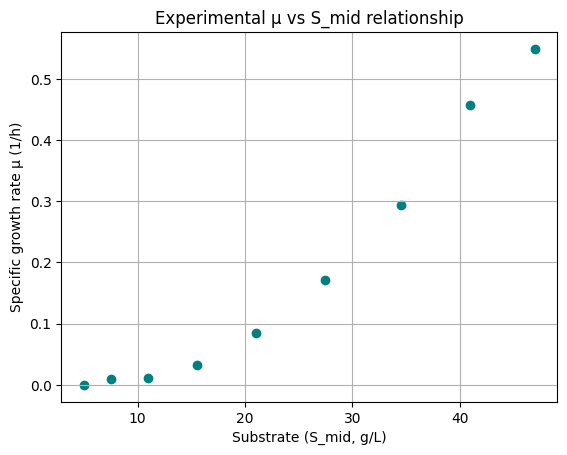

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(monod_df["S_mid"], monod_df["mu_est"], color="teal")
plt.xlabel("Substrate (S_mid, g/L)")
plt.ylabel("Specific growth rate μ (1/h)")
plt.title("Experimental μ vs S_mid relationship")
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Monod fonksiyonu (kinetik denklem)
def monod(S, mu_max, K_S):
    """
    μ(S) = μmax * S / (K_S + S)
    S: substrat (g/L)
    mu_max: maksimum büyüme hızı (1/h)
    K_S: yarı doygunluk sabiti (g/L)
    """
    return mu_max * S / (K_S + S)

# Dashboard için sürekli S ekseni (0.1-100 g/L aralığında 200 nokta)
S_range = np.linspace(0.1, 100, 200)

In [ ]:
from ipywidgets import interact, FloatSlider, Checkbox

def monod_plot(mu_max=1.0, K_S=20.0, show_data=True):
    """
    mu_max ve K_S slider'larıyla Monod eğrisini canlı günceller.
    show_data=True ise deneysel (S_mid, μ_est) noktalarını da çizer.
    """
    μ = monod(S_range, mu_max, K_S)

    plt.figure(figsize=(7,5))
    plt.plot(S_range, μ, linewidth=2, label=f"Monod fit (μmax={mu_max:.2f}, K_S={K_S:.1f})")

    # İstenirse deneysel noktaları da göster (Hücre 2'de oluşturulan monod_df'den)
    if show_data and 'monod_df' in globals():
        plt.scatter(monod_df["S_mid"], monod_df["mu_est"], s=55, alpha=0.85, label="Data (S_mid vs μ)")
    elif show_data:
        print("Uyarı: monod_df bulunamadı. (Hücre 2'yi çalıştırdığından emin ol.)")

    plt.xlabel("Substrate (S, g/L)")
    plt.ylabel("Growth rate μ (1/h)")
    plt.title("Interactive Monod Dashboard")
    plt.grid(True)
    plt.legend()
    plt.show()

# Interaktif widget: iki slider + bir checkbox
interact(
    monod_plot,
    mu_max=FloatSlider(min=0.1, max=2.0, step=0.1, value=1.0, description='μmax'),
    K_S=FloatSlider(min=1, max=100, step=5, value=20, description='K_S'),
    show_data=Checkbox(value=True, description="Show experimental points")
);

interactive(children=(FloatSlider(value=1.0, description='μmax', max=2.0, min=0.1), FloatSlider(value=20.0, de…

In [ ]:
from IPython.display import Markdown, display

def explain_panel(mu_max, K_S):
    text = f"""
### 📊 Monod Interpretation
- **μmax = {mu_max:.2f} 1/h** → Sistemin erişebileceği tavan büyüme hızı.
- **Kₛ = {K_S:.1f} g/L** → μ’nin yarısına ulaştığı substrat düzeyi (yarı doygunluk).
- **Küçük Kₛ** → Erken doygunluk, yüksek substrat afinitesi (verimli kullanım).
- **Büyük Kₛ** → Geç doygunluk, düşük substrat afinitesi (yüksek S gerekir).
"""
    display(Markdown(text))

interact(
    explain_panel,
    mu_max=FloatSlider(min=0.1, max=2.0, step=0.1, value=1.0, description='μmax'),
    K_S=FloatSlider(min=1, max=100, step=5, value=20, description='K_S')
);

interactive(children=(FloatSlider(value=1.0, description='μmax', max=2.0, min=0.1), FloatSlider(value=20.0, de…

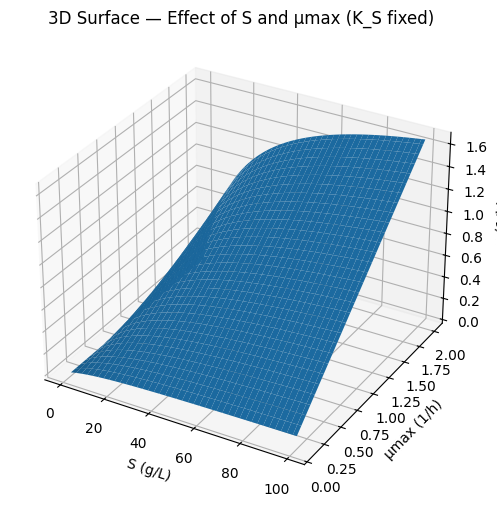

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

S_grid = np.linspace(0.1, 100, 120)
mu_max_grid = np.linspace(0.1, 2.0, 60)
S_mesh, mu_max_mesh = np.meshgrid(S_grid, mu_max_grid)

K_S_fixed = 20.0
mu_surface = monod(S_mesh, mu_max_mesh, K_S_fixed)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(S_mesh, mu_max_mesh, mu_surface)
ax.set_xlabel("S (g/L)"); ax.set_ylabel("μmax (1/h)"); ax.set_zlabel("μ (1/h)")
ax.set_title("3D Surface — Effect of S and μmax (K_S fixed)")
plt.show()

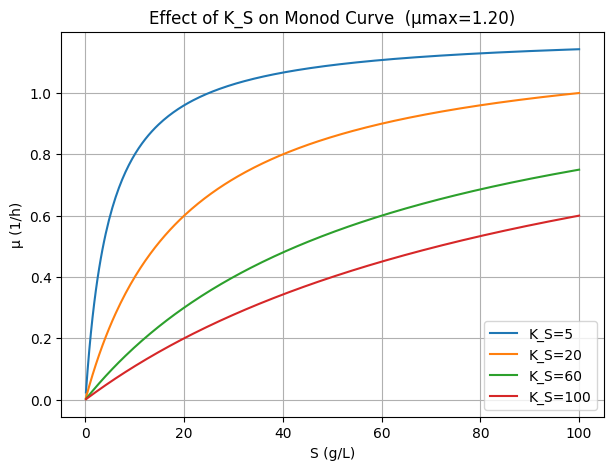

In [ ]:
S_line = np.linspace(0.1, 100, 300)
mu_max_demo = 1.2  # örnek: sabit bir μmax
Ks_values = [5, 20, 60, 100]

plt.figure(figsize=(7,5))
for Ks in Ks_values:
    μ_line = monod(S_line, mu_max_demo, Ks)
    plt.plot(S_line, μ_line, label=f"K_S={Ks}")
plt.xlabel("S (g/L)"); plt.ylabel("μ (1/h)")
plt.title(f"Effect of K_S on Monod Curve  (μmax={mu_max_demo:.2f})")
plt.grid(True); plt.legend(); plt.show()